In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [61]:
using_colab = False

In [62]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [4]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

## Example image

In [5]:
mult_masks = []
images = []


In [6]:
image = Image.open('images/bunny_views/view_0.png')
image = np.array(image.convert("RGB"))

In [7]:
images.append(image)

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [8]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [9]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [10]:
print(len(masks))
print(masks[0].keys())

9
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
mult_masks.append(masks)

In [12]:
len(mult_masks)

1

Show all the masks overlayed on the image.

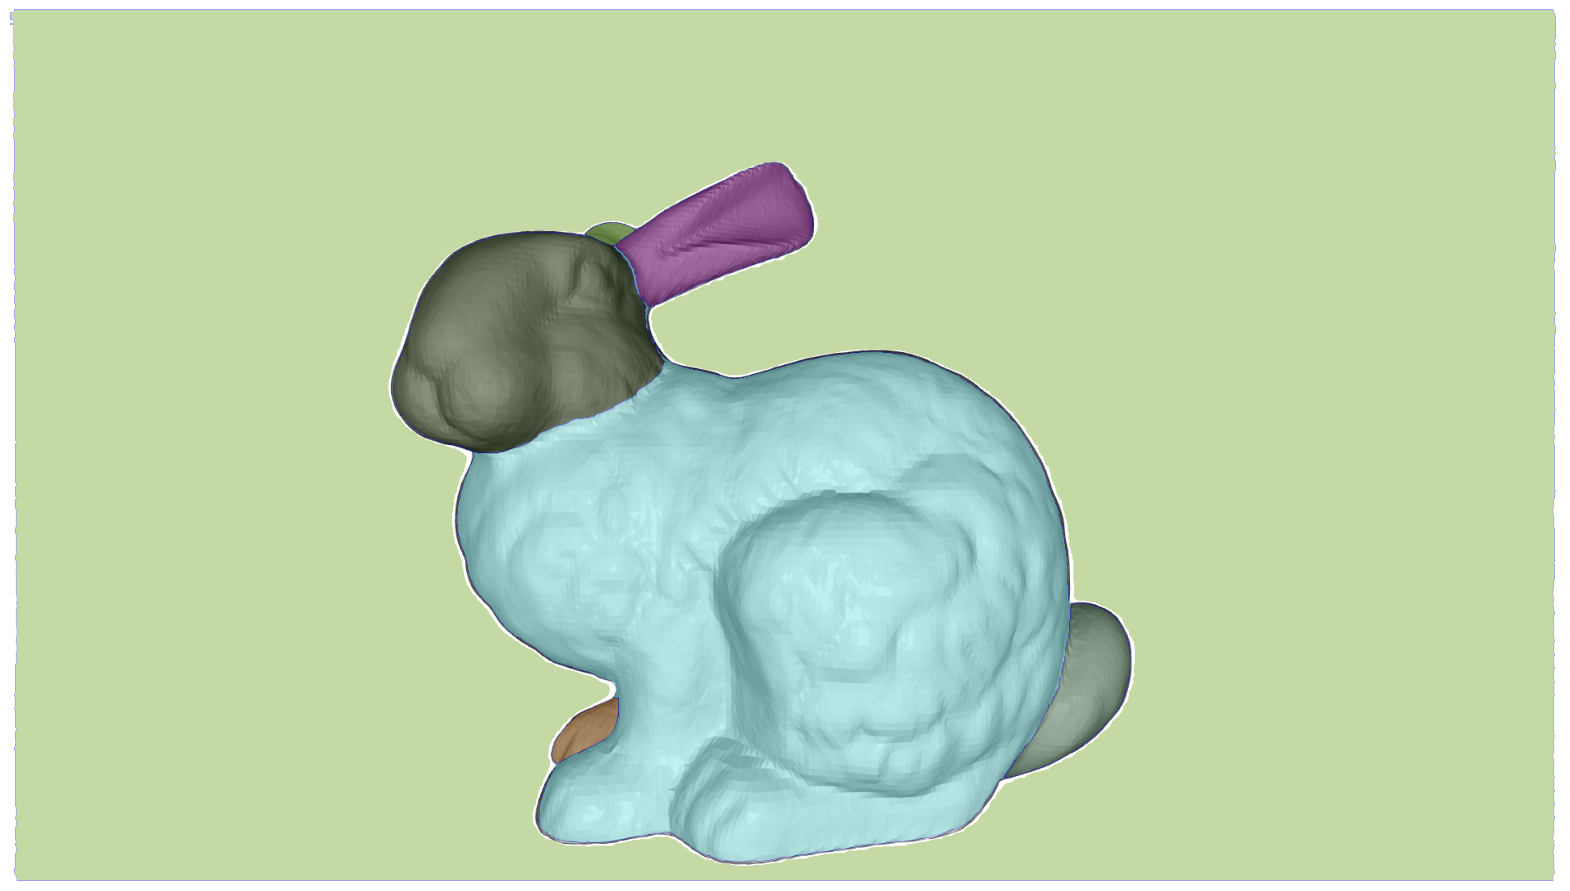

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [14]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms as T
# Load CLIP model from Hugging Face
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def mask_to_image(original_image, mask_dict):
    """Apply a SAM-generated mask to an image."""
    mask = mask_dict["segmentation"]  # Extract boolean mask

    image_array = np.array(original_image)
    masked_image = np.zeros_like(image_array)  # Black background
    masked_image[mask] = image_array[mask]  # Apply mask
    
    return Image.fromarray(masked_image)

def get_text_embedding(text):
    """ Get CLIP embedding of a text query. """
    inputs = processor(text=[text], return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features / text_features.norm(dim=-1, keepdim=True)

def get_clip_embedding(image):
    """ Get CLIP embedding of an image. """
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features / image_features.norm(dim=-1, keepdim=True)

def rank_masks_by_similarity(image, masks, query):
    """ Rank SAM masks based on similarity to the query using CLIP. """
    text_embedding = get_text_embedding(query)

    scores = []
    for mask_dict in masks:  # Each mask is a dictionary
        masked_image = mask_to_image(image, mask_dict)
        image_embedding = get_clip_embedding(masked_image)

        # Compute cosine similarity
        similarity = (image_embedding @ text_embedding.T).item()
        scores.append((similarity, mask_dict))

    # Sort masks by similarity score
    scores.sort(reverse=True, key=lambda x: x[0])
    return scores  # Returns sorted masks with scores


top_masks = rank_masks_by_similarity(image, masks, "ear")

# Get the most relevant mask
best_mask = top_masks[0][1]["segmentation"]

In [15]:
# mult masks
count = 1
for mask in mult_masks:
    image = Image.open('images/bunny_views/view_{count}.png')
    image = np.array(image.convert("RGB"))
    top_masks = rank_masks_by_similarity(image, mask, "ear")
    best_mask = top_masks[0][1]["segmentation"]
    count -= 1

FileNotFoundError: [Errno 2] No such file or directory: 'images/bunny_views/view_{count}.png'

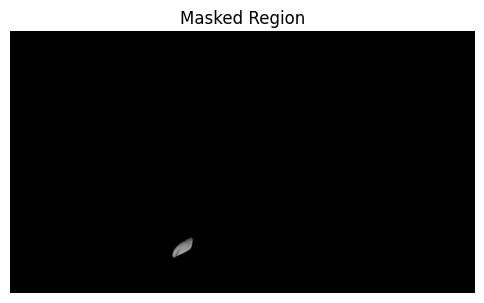

In [49]:
masked_image = mask_to_image(image, {"segmentation": best_mask})
plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.axis("off")
plt.title("Masked Region")
plt.show()


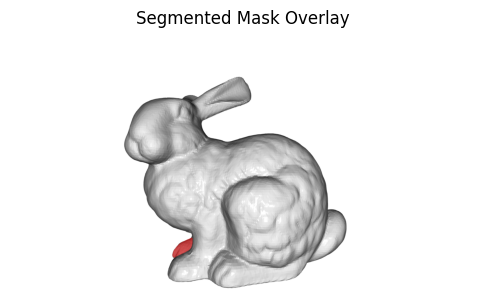

In [50]:
import matplotlib.pyplot as plt

def visualize_mask(original_image, mask, alpha=0.5):
    """Overlay the SAM mask on the original image with transparency."""
    image_array = np.array(original_image)

    # Create an RGBA version of the image
    overlay = image_array.copy()
    overlay[mask] = [255, 0, 0]  # Color the mask region red

    # Blend the original image and the overlay
    blended = (1 - alpha) * image_array + alpha * overlay
    blended = blended.astype(np.uint8)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.axis("off")
    plt.title("Segmented Mask Overlay")
    plt.show()

# Call the function with the best mask
visualize_mask(image, best_mask)


In [ ]:
import numpy as np

def merge_masks(mult_masks):
    """
    Merge multiple binary masks into one unified mask by taking the logical OR.
    
    Args:
    - masks (list of np.array): List of binary masks from different views.
    
    Returns:
    - merged_mask (np.array): The merged mask.
    """
    # Initialize merged mask as the first mask
    merged_mask = mult_masks[0]
    
    # Combine all masks using a logical OR operation
    for mask in mult_masks[1:]:
        merged_mask = np.logical_or(merged_mask, mask)
    
    return merged_mask.astype(bool)


def backproject_to_3d(point_2d, camera_matrix, depth_map):
    """
    Back-project a 2D point into 3D space using the camera matrix and depth map.
    
    Args:
    - point_2d (np.array): 2D point in image coordinates (x, y).
    - camera_matrix (np.array): Camera intrinsic matrix (3x3).
    - depth_map (np.array): Depth map of the scene (same size as image).
    
    Returns:
    - point_3d (np.array): 3D point in camera coordinates (X, Y, Z).
    """
    # Get the depth value of the point from the depth map
    depth = depth_map[point_2d[1], point_2d[0]]

    # Convert the 2D point to homogeneous coordinates (x, y, 1)
    point_2d_homogeneous = np.array([point_2d[0], point_2d[1], 1])

    # Use the camera matrix to compute the corresponding 3D point
    point_3d_homogeneous = np.linalg.inv(camera_matrix) @ point_2d_homogeneous * depth
    return point_3d_homogeneous[:3]  # Return the 3D coordinates (X, Y, Z)


def merge_masks_3d(masks, camera_matrices, depth_maps):
    """
    Merge the 2D masks into a single 3D point cloud.
    
    Args:
    - masks (list of np.array): List of binary masks for each view.
    - camera_matrices (list of np.array): List of camera intrinsic matrices for each view.
    - depth_maps (list of np.array): List of depth maps corresponding to each view.
    
    Returns:
    - point_cloud (np.array): A point cloud containing all the back-projected 3D points.
    """
    point_cloud = []

    # First, merge all masks in 2D
    merged_mask = merge_masks(masks)

    # Now, for the merged mask, back-project the points into 3D
    for i, mask in enumerate(masks):
        camera_matrix = camera_matrices[i]
        depth_map = depth_maps[i]
        
        # Iterate through each pixel in the merged mask (foreground pixels are True)
        for y in range(merged_mask.shape[0]):
            for x in range(merged_mask.shape[1]):
                if merged_mask[y, x]:  # If this pixel is part of the merged segmentation
                    point_2d = np.array([x, y])
                    point_3d = backproject_to_3d(point_2d, camera_matrix, depth_map)
                    point_cloud.append(point_3d)
    
    return np.array(point_cloud)

import open3d as o3d

def visualize_point_cloud(point_cloud):
    """Visualize the point cloud using Open3D."""
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(point_cloud)
    o3d.visualization.draw_geometries([pc])

# Example usage
# masks: list of 2D binary masks for each view
# camera_matrices: list of intrinsic camera matrices for each view
# depth_maps: list of depth maps for each view
point_cloud = merge_masks_3d(mult_masks, camera_matrices, depth_maps)
visualize_point_cloud(point_cloud)


## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [13]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [ ]:
masks2 = mask_generator_2.generate(image)

/Users/idilkpkrn/Desktop/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/Users/idilkpkrn/Desktop/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(
2025-03-17 16:57:23.754 Python[33313:37223730] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-33313-2025-03-17_16_57_23-1162507854‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2025-03-17 16:57:23.811 Python[33313:37223730] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-33313-2025-03-17_16_57_23-1297791682‚Äù because the volume ‚ÄúMacintosh HD‚Äù is 

## Save as Images

In [84]:
import open3d as o3d
import numpy as np

bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

#pcd = mesh.sample_points_uniformly(number_of_points=500)
#o3d.visualization.draw_geometries([pcd])

2025-03-18 01:58:53.169 Python[1324:10396] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-18 01:58:53.169 Python[1324:10396] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh)

angles = [0, 45, 90, 135, 180, 225, 270]
for i, angle in enumerate(angles):
    ctr = vis.get_view_control()
    ctr.rotate(angle, 0)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(f"images/bunny_views/view_{i}.png")

vis.destroy_window()

: 